For this code, need to use python 3 kernel and not LELEC210X kernel!

https://www.tensorflow.org/tutorials/audio/simple_audio
https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb
https://nmbu.brage.unit.no/nmbu-xmlui/bitstream/handle/11250/2611624/report-print1.pdf?sequence=3&isAllowed=y


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA
import pickle
from pathlib import Path
from typing import List, Tuple
import glob

from classification.datasets import Dataset

from classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from classification.utils.utils import accuracy
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

2024-04-19 12:20:48.884025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 12:20:48.923707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 12:20:48.932377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 12:20:49.782330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
#!pip install --upgrade pip # update pip if needed

In [6]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [7]:
#pip install scikeras

In [8]:
#!pip list

In [9]:
model_dir = "../goldenProject/python/modelCNN/"
fv_dir = "../goldenProject/python/bigbigbigDataset/"

<font size=5 color=#009999> 1. Our dataset </font> <br>

<font size=4 color=#009999> 1.1 Build matrix of fv </font> <br>

In [10]:
def get_cls_from_path(file):
    return file.stem.split("_", maxsplit=1)[0]


format = "pickle"
classnames = ['birds','chainsaw','fire','handsaw','helicopter']

#fv = pickle.load(open(fv_dir + filename, 'rb'))
#print(fv)
#print(fv.shape)

dic_fv = {}
for file in sorted((Path(fv_dir)).glob("**/*." + format)):
    #print(str(file))
    fv = pickle.load(open(file, 'rb'))
    fv = np.squeeze(fv)
    cls = get_cls_from_path(file)
    #print(cls)
    dic_fv.setdefault(cls, []).append(fv)
print(dic_fv)

nclass = len(dic_fv)
naudio = len(dic_fv[list(dic_fv.keys())[0]])
size = nclass * naudio

print(nclass)
print(naudio)
print(size)

# plt.figure()
# plot_specgram(fv.reshape((20, 20)).T, ax=plt.gca(), is_mel=True, title="MEL Spectrogram", xlabel="Mel vector")
# plt.show()


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
### Features vectors build matrix ###

train_pct = 0.7
print(len(dic_fv["birds"][0]))
featveclen = len(dic_fv["birds"][0]) # number of items in a feature vector
#nitems = size
nlearn = round(naudio * train_pct) # number of sounds among naudio for training
fm_dir = "data/feature_matrices2/"

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio*data_aug_factor) #matrice avec les noms des classes x le nombre de sons (40 de base)

X = np.zeros((data_aug_factor*size, featveclen)) #nombre de sons total x taille du feature vector
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = dic_fv[classname][idx] #melspec
            X[s*nclass*naudio+class_idx*naudio+idx,:] = featvec       
#np.save(fm_dir+"feature_matrix_2D_Bby.npy", X)


400


In [12]:
#X = np.load(fm_dir+"feature_matrix_2D_Bby.npy")

# "Labels"
y = class_ids_aug.copy() #noms des sons

print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

print()

Shape of the feature matrix : (2000, 400)
Number of labels : 2000



<font size=4 color=#009999> 1.3 Build data and split it </font> <br>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y) # random_state=1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, stratify=y_train, random_state=1)

nbre_nan = np.count_nonzero(np.isnan(X_train))
print("Nombre de NaN dans la matrice :", nbre_nan)

print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of Y_val: ", y_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", y_test.shape)

Nombre de NaN dans la matrice : 0
Shape of X_train:  (1602, 400)
Shape of Y_train:  (1602,)
Shape of X_val:  (198, 400)
Shape of Y_val:  (198,)
Shape of X_test:  (200, 400)
Shape of Y_test:  (200,)


In [14]:
# [2] (optional) Data normalization
X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_val = X_val / np.linalg.norm(X_val, axis=1, keepdims=True)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)


#  reshape by N_Melvec x Melvec_length x 1
X_train = X_train.reshape(len(X_train), 20, 20, 1)
y_train = y_train.reshape(len(y_train),)

X_val = X_val.reshape(len(X_val), 20, 20, 1)
y_val = y_val.reshape(len(y_val),)

X_test = X_test.reshape(len(X_test), 20, 20, 1)
y_test = y_test.reshape(len(y_test),)


print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of Y_val: ", y_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", y_test.shape)

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train) # Reshape labels to (n_samples,)
y_val_encoded = label_encoder.fit_transform(y_val) # Reshape labels to (n_samples,)
y_encoded = label_encoder.fit_transform(y)

Shape of X_train:  (1602, 20, 20, 1)
Shape of Y_train:  (1602,)
Shape of X_val:  (198, 20, 20, 1)
Shape of Y_val:  (198,)
Shape of X_test:  (200, 20, 20, 1)
Shape of Y_test:  (200,)


In [15]:
import time

start_time = time.time()

# [4] Model plus facile xD
def create_model(num_filters=32, units = 64, drop_rate = 0):
    input_shape = (20, 20, 1)
    num_labels = 5

    model = Sequential()
    model.add(Conv2D(num_filters, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(num_filters, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


keras_model = KerasClassifier(model=create_model, num_filters=8, units = 64, drop_rate = 0, verbose=0)

param_keys = keras_model.get_params().keys()
print("Parameter keys:", param_keys)


param_grid = {
    'num_filters': [4, 8, 16, 32, 64],
    'drop_rate': [0,0.2,0.3,0.4],
    'units': [4, 8, 16, 32, 64, 128],
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)

keras_model.get_params().keys()

# Fit the GridSearchCV object to the data
X_reshape = X.reshape(len(X), 20, 20, 1)
grid_search.fit(X_reshape, y_encoded)


end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")


# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


# Create lists to store parameters and corresponding scores
num_filters = param_grid['num_filters']
drop_rate = param_grid['drop_rate']
units = param_grid['units']


Parameter keys: dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'num_filters', 'units', 'drop_rate', 'class_weight'])


2024-04-19 12:22:28.766482: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26375328 exceeds 10% of free system memory.
2024-04-19 12:22:28.766890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26375328 exceeds 10% of free system memory.
2024-04-19 12:22:28.768203: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21601728 exceeds 10% of free system memory.
2024-04-19 12:22:28.771551: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26375328 exceeds 10% of free system memory.
2024-04-19 12:22:28.771584: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26375328 exceeds 10% of free system memory.


Elapsed time: 447.73768877983093 seconds
Best parameters found:  {'drop_rate': 0, 'num_filters': 64, 'units': 32}
Best accuracy found:  0.6340185762974369


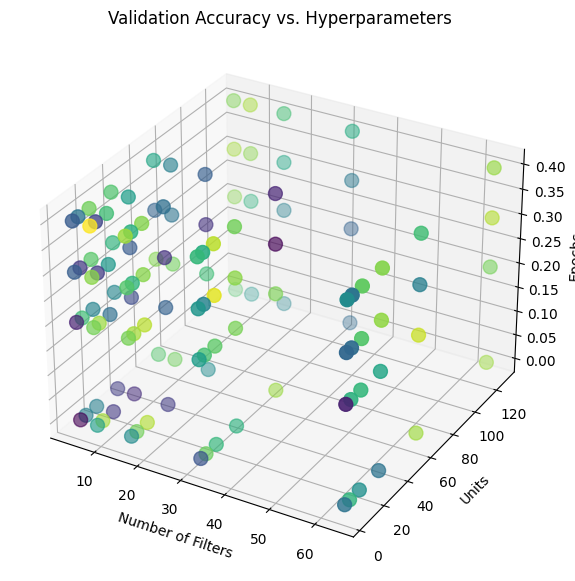

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# Extract results from the grid search
results = grid_search.cv_results_
mean_val_scores = results['mean_test_score']

# Reshape the scores to match the parameter grid shape
num_filters_grid = np.array(param_grid['num_filters'])
units_grid = np.array(param_grid['units'])
epochs_grid = np.array(param_grid['drop_rate'])
num_filters_grid, units_grid, epochs_grid = np.meshgrid(num_filters_grid, units_grid, epochs_grid, indexing='ij')
mean_val_scores = mean_val_scores.reshape(num_filters_grid.shape)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(num_filters_grid, units_grid, epochs_grid, c=mean_val_scores, cmap='viridis', s=100)
ax.set_xlabel('Number of Filters')
ax.set_ylabel('Units')
ax.set_zlabel('Epochs')
ax.set_title('Validation Accuracy vs. Hyperparameters')
plt.show()

In [42]:
results = grid_search.cv_results_

# Extract mean test scores
mean_test_scores = np.array(results['mean_test_score']).reshape(len(param_grid['num_filters']), len(param_grid['epochs']))

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')
plt.title('Grid Search Mean Test Scores')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Num filters',fontsize=14)
plt.colorbar()
plt.xticks(np.arange(len(param_grid['epochs'])), param_grid['epochs'],fontsize=14)
plt.yticks(np.arange(len(param_grid['num_filters'])), param_grid['num_filters'],fontsize=14)
plt.tight_layout()
#plt.savefig('gridSearchScores.pdf')
plt.show()

ValueError: cannot reshape array of size 120 into shape (4,6)

<font size=4 color=#009999> Results sur model plus complexe </font> <br>

In [31]:
# [3] (optional) dimensionality reduction.

In [32]:
# [4] Model training and selection
def create_model(num_filters=32, dropout_rate = 0.2):
    input_shape = (20, 20, 1)
    num_labels = 5

    model = Sequential()
    model.add(Conv2D(num_filters, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(num_filters, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


keras_model = KerasClassifier(model=create_model, num_filters=8, dropout_rate=.2, verbose=0)

param_keys = keras_model.get_params().keys()
print("Parameter keys:", param_keys)


param_grid = {
    'num_filters': [8, 16, 32, 64],
    'dropout_rate': [.2,.3,.4,.5],
    'epochs': [10, 20, 30, 40, 50],
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)

keras_model.get_params().keys()

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train_encoded)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


# Create lists to store parameters and corresponding scores
batch_sizes = param_grid['num_filters']
epochs = param_grid['epochs']
dropout_rate = param_grid['dropout_rate']


Parameter keys: dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'num_filters', 'dropout_rate', 'class_weight'])
Best parameters found:  {'dropout_rate': 0.3, 'epochs': 40, 'num_filters': 64}
Best accuracy found:  0.9313358302122346


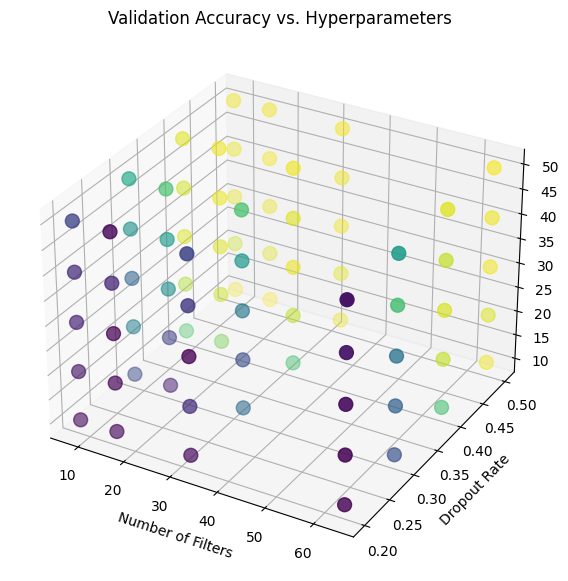

In [33]:
from mpl_toolkits.mplot3d import Axes3D

# Extract results from the grid search
results = grid_search.cv_results_
mean_val_scores = results['mean_test_score']

# Reshape the scores to match the parameter grid shape
num_filters_grid = np.array(param_grid['num_filters'])
dropout_rate_grid = np.array(param_grid['dropout_rate'])
epochs_grid = np.array(param_grid['epochs'])
num_filters_grid, dropout_rate_grid, epochs_grid = np.meshgrid(num_filters_grid, dropout_rate_grid, epochs_grid, indexing='ij')
mean_val_scores = mean_val_scores.reshape(num_filters_grid.shape)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(num_filters_grid, dropout_rate_grid, epochs_grid, c=mean_val_scores, cmap='viridis', s=100)
ax.set_xlabel('Number of Filters')
ax.set_ylabel('Dropout Rate')
ax.set_zlabel('Epochs')
ax.set_title('Validation Accuracy vs. Hyperparameters')
plt.show()

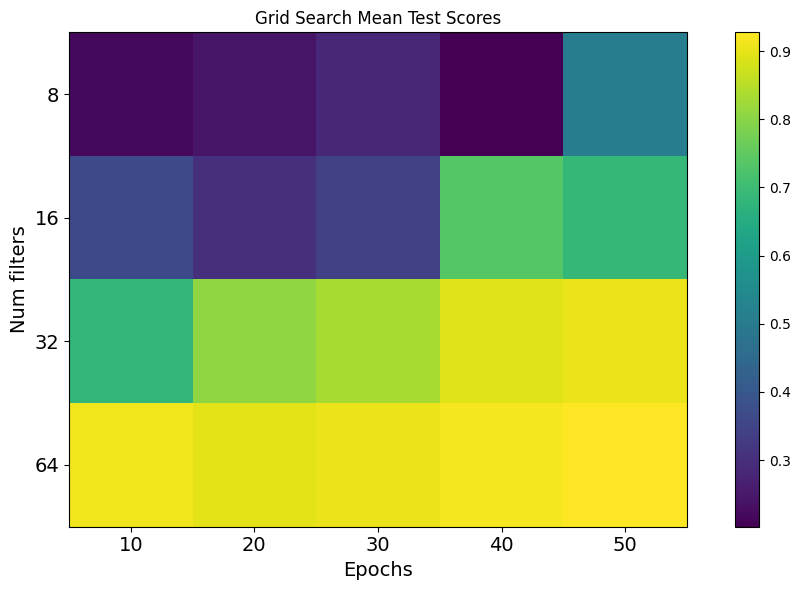

In [30]:
results = grid_search.cv_results_

# Extract mean test scores
mean_test_scores = np.array(results['mean_test_score']).reshape(len(param_grid['num_filters']), len(param_grid['epochs']))

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')
plt.title('Grid Search Mean Test Scores')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Num filters',fontsize=14)
plt.colorbar()
plt.xticks(np.arange(len(param_grid['epochs'])), param_grid['epochs'],fontsize=14)
plt.yticks(np.arange(len(param_grid['num_filters'])), param_grid['num_filters'],fontsize=14)
plt.tight_layout()
#plt.savefig('gridSearchScores.pdf')
plt.show()
